# Dataset Testing

While the repository features a vast amount of data in general this won't be the case and obtaining data is often the most expensive task. Therefore, I'm trying out different ways of sampling the available data and look at the results. It seems reasonable to assume that 2000 generated data points are available which will be split into training, validation and testing.

First way of selecting data will be random sampling.\
Second, uniformly sampling across the (n_core-n_clad=x)-subsets.\
Third, maximizing "coverage".

Testing could also be done against the whole dataset.

In [1]:
if "google.colab" in str(get_ipython()):
    !pip install ipython-autotime
    !pip install numpy_indexed
    %load_ext autotime
    COLAB = True
    !rm -rf ML_2DWVG
    !git clone https://github.com/exc4l/ML_2DWVG
    datadir = "ML_2DWVG/data/"
    from google.colab import files

Cloning into 'ML_2DWVG'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 2), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (13/13), done.
time: 825 ms (started: 2021-05-24 07:08:31 +00:00)


In [2]:
import ML_2DWVG.libML as lml
import os
import tensorflow as tf
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
# import tensorflow_addons as tfa
import tqdm

# from tqdm.keras import TqdmCallback

plt.rcParams["figure.figsize"] = [12, 8]
from sys import getsizeof
import numpy_indexed as npi
from zipfile import ZipFile
import shutil

time: 1.58 s (started: 2021-05-24 07:08:32 +00:00)


In [3]:
# training parameters for all
lr = 0.01
batchz = 32
epochs = 10000

time: 1.5 ms (started: 2021-05-24 07:08:34 +00:00)


In [4]:
data_arr = np.genfromtxt(f"{datadir}2dwvg_1550.csv", delimiter=",")
input_shape = (5,)

time: 924 ms (started: 2021-05-24 07:08:34 +00:00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd7d913e50>,
      dtype=object)

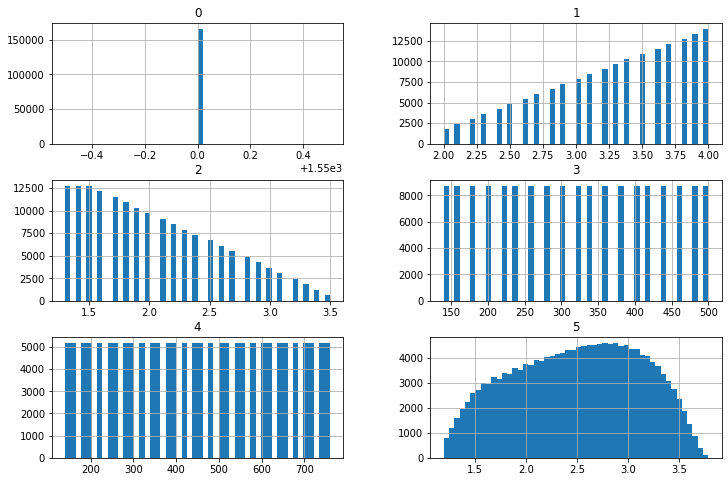

time: 1.32 s (started: 2021-05-24 07:08:34 +00:00)


In [5]:
lml.np_hist(data_arr)

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = lml.get_sample_data_to_train(
    data_arr, 2000, train_size=0.8, val_size=0.1, test_size=0.1
)

(1600, 5)
time: 5.04 ms (started: 2021-05-24 07:08:36 +00:00)


In [7]:
# define learning rate and optimizer as well as regularizers
opt = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
l1reg = tf.keras.regularizers.L1L2(l1=0.000001, l2=0.000001)

time: 3.71 ms (started: 2021-05-24 07:08:36 +00:00)


In [8]:
# 4 layers with 400 neurons each
randmodel = tf.keras.Sequential()
randmodel.add(tf.keras.Input(shape=input_shape))
randmodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
randmodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
randmodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
randmodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
randmodel.add(tf.keras.layers.Dense(1))
randmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
time: 700 ms (started: 2021-05-24 07:08:36 +00:00)


In [9]:
randmodel.compile(
    optimizer=opt,
    loss="mse",
    metrics=["mse", "mae", "logcosh", "mean_absolute_percentage_error"],
)

time: 14.7 ms (started: 2021-05-24 07:08:37 +00:00)


In [10]:
history = randmodel.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    #     batch_size=len(X_train),
    batch_size=batchz,
    epochs=epochs,
    verbose=0,
    callbacks=[
        lml.TrainingToFileLogger(force=True, file="randomsampling.log"),
    ],
)

time: 19min 46s (started: 2021-05-24 07:08:37 +00:00)


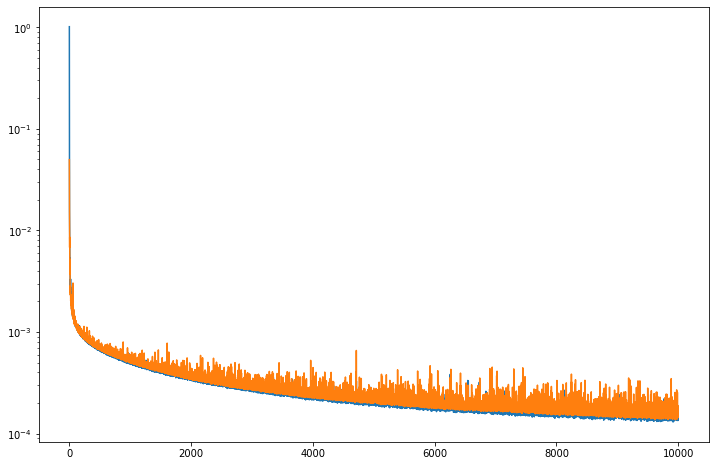

time: 1.04 s (started: 2021-05-24 07:28:23 +00:00)


In [11]:
lml.print_training_log("randomsampling.log", onlyloss=True)

In [12]:
randfol="rand_ndiff"
!mkdir {randfol}
maelist = list()
errorpd = pd.DataFrame()
for diff in np.arange(0.1, 4, 0.1):
    a = lml.n2n1diff_search(data_arr, diff, 1, 2)
    if len(a) < 1:
        continue
    testdiffx = a[:, :-1]
    testdiffy = a[:, -1]
    testdiffy = testdiffy.reshape(len(testdiffy), 1)
    testdiffxtr = scaler.transform(testdiffx)
    testres = randmodel(testdiffxtr).numpy().astype(float)
    maer = np.mean(np.abs(testres-testdiffy))
    maelist.append([diff, maer])
    metdict = {"diff": diff}
    metdict.update(lml.get_metric_scores(testres, testdiffy))
    add_data = [metdict]
    errorpd = errorpd.append(add_data, ignore_index=True, sort=False)
    unique, mean = npi.group_by(testdiffx[:, -2:]).mean(np.abs(testres - testdiffy))
    # instead of averaging over all values take maxerror at each height,width
    # since the higher ndiffs can't really average
    _, maxerr = npi.group_by(testdiffx[:, -2:]).max(np.abs(testres - testdiffy))
    np.savetxt(f"{randfol}/{diff:.1f}coo.csv", unique, delimiter=",")
    np.savetxt(f"{randfol}/{diff:.1f}val.csv", mean, delimiter=",")
    np.savetxt(f"{randfol}/{diff:.1f}maxval.csv", maxerr, delimiter=",")
errorpd.to_csv(f"{randfol}/errormetrics.csv", index_label="Index")
!zip -r {randfol}.zip {randfol}
files.download(f"{randfol}.zip")

mkdir: cannot create directory ‘rand_ndiff’: File exists
updating: rand_ndiff/ (stored 0%)
updating: rand_ndiff/2.5val.csv (deflated 54%)
updating: rand_ndiff/1.1val.csv (deflated 55%)
updating: rand_ndiff/2.3maxval.csv (deflated 54%)
updating: rand_ndiff/1.9coo.csv (deflated 94%)
updating: rand_ndiff/0.6maxval.csv (deflated 55%)
updating: rand_ndiff/2.5coo.csv (deflated 94%)
updating: rand_ndiff/2.6coo.csv (deflated 94%)
updating: rand_ndiff/1.2coo.csv (deflated 94%)
updating: rand_ndiff/1.2maxval.csv (deflated 55%)
updating: rand_ndiff/1.7val.csv (deflated 55%)
updating: rand_ndiff/2.2coo.csv (deflated 94%)
updating: rand_ndiff/1.2val.csv (deflated 55%)
updating: rand_ndiff/0.5val.csv (deflated 55%)
updating: rand_ndiff/1.4val.csv (deflated 55%)
updating: rand_ndiff/1.1coo.csv (deflated 94%)
updating: rand_ndiff/0.9val.csv (deflated 55%)
updating: rand_ndiff/1.0val.csv (deflated 55%)
updating: rand_ndiff/2.0coo.csv (deflated 94%)
updating: rand_ndiff/1.7maxval.csv (deflated 55%)
upda

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 705 ms (started: 2021-05-24 07:28:24 +00:00)


In [13]:
# sample randomly at each different absolute n2-n1
totsam = list()
for diff in np.arange(0.1, 4, 0.1):
    a = lml.n2n1diff_search(data_arr, diff, 1, 2)
    if len(a) < 1:
        continue
    # print(diff, len(a))
    sam = lml.get_np_sample(a, sample=70)
    totsam.append(sam)
totsam_arr = np.concatenate(totsam, axis=0)
totsam_arr.shape

(1610, 6)

time: 58.4 ms (started: 2021-05-24 07:28:25 +00:00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd7dcd9fd0>,
      dtype=object)

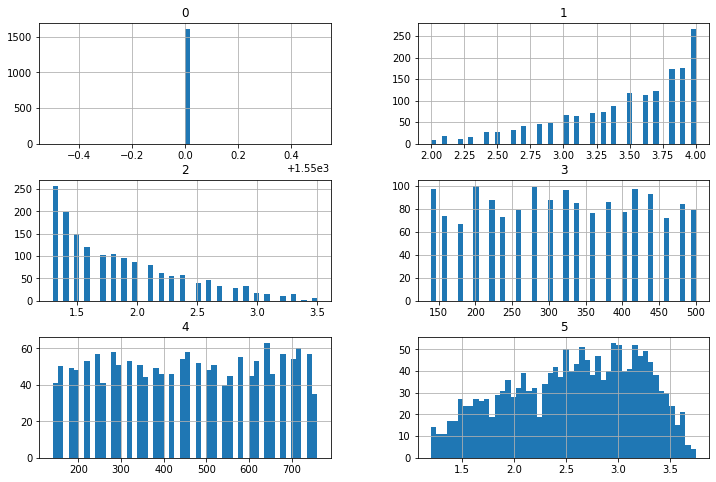

time: 1.46 s (started: 2021-05-24 07:28:25 +00:00)


In [14]:
lml.np_hist(totsam_arr)

In [15]:
#define training data and scaling
X_train = totsam_arr[:,:-1]
y_train = totsam_arr[:,-1]
val_arr = lml.get_np_sample(data_arr, sample=200)
X_val = val_arr[:,:-1]
y_val = val_arr[:,-1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

time: 6.94 ms (started: 2021-05-24 07:28:26 +00:00)


In [16]:

opt = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
l1reg = tf.keras.regularizers.L1L2(l1=0.000001, l2=0.000001)
# 4 layers with 400 neurons each
unifmodel = tf.keras.Sequential()
unifmodel.add(tf.keras.Input(shape=input_shape))
unifmodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
unifmodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
unifmodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
unifmodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
unifmodel.add(tf.keras.layers.Dense(1))
unifmodel.summary()
unifmodel.compile(
    optimizer=opt,
    loss="mse",
    metrics=["mse", "mae", "logcosh", "mean_absolute_percentage_error"],
)

history = unifmodel.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    #     batch_size=len(X_train),
    batch_size=batchz,
    epochs=epochs,
    verbose=0,
    callbacks=[
        lml.TrainingToFileLogger(force=True, file="unifsampling.log"),
    ],
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
time: 24min 47s (started: 2021-05-24 07:28:26 +00:00)


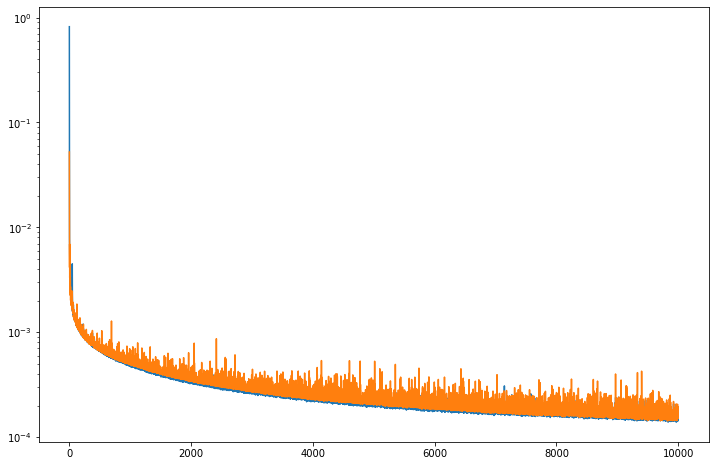

time: 1.02 s (started: 2021-05-24 07:53:14 +00:00)


In [17]:
lml.print_training_log("unifsampling.log", onlyloss=True)

In [18]:
randfol="unif_ndiff"
!mkdir {randfol}
maelist = list()
errorpd = pd.DataFrame()
for diff in np.arange(0.1, 4, 0.1):
    a = lml.n2n1diff_search(data_arr, diff, 1, 2)
    if len(a) < 1:
        continue
    testdiffx = a[:, :-1]
    testdiffy = a[:, -1]
    testdiffy = testdiffy.reshape(len(testdiffy), 1)
    testdiffxtr = scaler.transform(testdiffx)
    testres = unifmodel(testdiffxtr).numpy().astype(float)
    maer = np.mean(np.abs(testres-testdiffy))
    maelist.append([diff, maer])
    metdict = {"diff": diff}
    metdict.update(lml.get_metric_scores(testres, testdiffy))
    add_data = [metdict]
    errorpd = errorpd.append(add_data, ignore_index=True, sort=False)
    unique, mean = npi.group_by(testdiffx[:, -2:]).mean(np.abs(testres - testdiffy))
    # instead of averaging over all values take maxerror at each height,width
    # since the higher ndiffs can't really average
    _, maxerr = npi.group_by(testdiffx[:, -2:]).max(np.abs(testres - testdiffy))
    np.savetxt(f"{randfol}/{diff:.1f}coo.csv", unique, delimiter=",")
    np.savetxt(f"{randfol}/{diff:.1f}val.csv", mean, delimiter=",")
    np.savetxt(f"{randfol}/{diff:.1f}maxval.csv", maxerr, delimiter=",")
errorpd.to_csv(f"{randfol}/errormetrics.csv", index_label="Index")
!zip -r {randfol}.zip {randfol}
files.download(f"{randfol}.zip")

mkdir: cannot create directory ‘unif_ndiff’: File exists
updating: unif_ndiff/ (stored 0%)
updating: unif_ndiff/2.5val.csv (deflated 55%)
updating: unif_ndiff/1.1val.csv (deflated 55%)
updating: unif_ndiff/2.3maxval.csv (deflated 55%)
updating: unif_ndiff/1.9coo.csv (deflated 94%)
updating: unif_ndiff/0.6maxval.csv (deflated 55%)
updating: unif_ndiff/2.5coo.csv (deflated 94%)
updating: unif_ndiff/2.6coo.csv (deflated 94%)
updating: unif_ndiff/1.2coo.csv (deflated 94%)
updating: unif_ndiff/1.2maxval.csv (deflated 56%)
updating: unif_ndiff/1.7val.csv (deflated 55%)
updating: unif_ndiff/2.2coo.csv (deflated 94%)
updating: unif_ndiff/1.2val.csv (deflated 55%)
updating: unif_ndiff/0.5val.csv (deflated 55%)
updating: unif_ndiff/1.4val.csv (deflated 55%)
updating: unif_ndiff/1.1coo.csv (deflated 94%)
updating: unif_ndiff/0.9val.csv (deflated 55%)
updating: unif_ndiff/1.0val.csv (deflated 55%)
updating: unif_ndiff/2.0coo.csv (deflated 94%)
updating: unif_ndiff/1.7maxval.csv (deflated 55%)
upda

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 753 ms (started: 2021-05-24 07:53:15 +00:00)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd7cd040d0>,
      dtype=object)

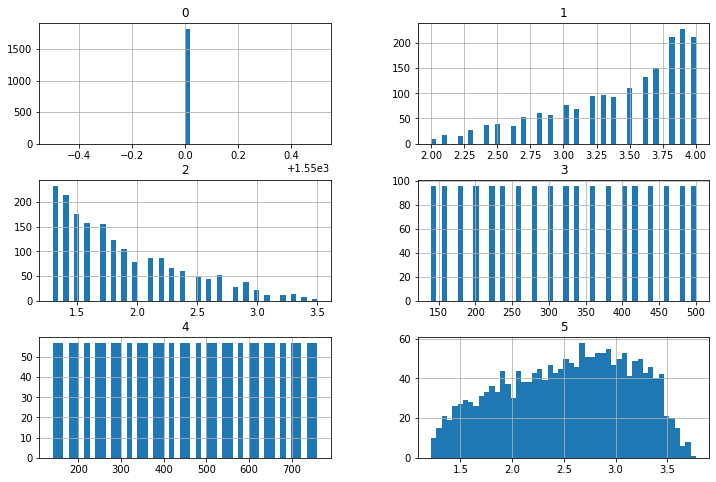

time: 3.62 s (started: 2021-05-24 07:53:16 +00:00)


In [19]:
index = npi.as_index(data_arr[:,-3:-1])
minndiff = min(np.abs(data_arr[:,2]-data_arr[:,1]))
maxndiff = max(np.abs(data_arr[:,2]-data_arr[:,1]))
ndiffs = list(np.arange(minndiff, maxndiff+0.05,0.1))
lndiffs = len(ndiffs) -1
unique_keys = index.unique
totsam = list()
idx = 0
for i in range(3):
    for h, w in unique_keys:
        #select data with h, w
        a = data_arr[np.logical_and(data_arr[:,-3]==h,data_arr[:,-2]==w)]
        #select current ndiff
        cidx = idx % lndiffs
        b = lml.n2n1diff_search(a, np.around(ndiffs[cidx],1), 1, 2)
        sam = lml.get_np_sample(b, sample=1)
        totsam.append(sam)
        idx+=1
        #1 data  point
        #loop again
totsam_arr = np.concatenate(totsam, axis=0)
totsam_arr.shape
lml.np_hist(totsam_arr)

In [20]:
#define training data and scaling
X = totsam_arr[:,:-1]
y = totsam_arr[:,-1]
X_train, X_val, y_train, y_val = lml.train_val_split(X, y, test_size=200)
# X_train = totsam_arr[:,:-1]
# y_train = totsam_arr[:,-1]
# val_arr = lml.get_np_sample(data_arr, sample=200)
# X_val = val_arr[:,:-1]
# y_val = val_arr[:,-1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

time: 5.47 ms (started: 2021-05-24 07:53:19 +00:00)


In [21]:

opt = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
l1reg = tf.keras.regularizers.L1L2(l1=0.000001, l2=0.000001)
# 4 layers with 400 neurons each
cyclemodel = tf.keras.Sequential()
cyclemodel.add(tf.keras.Input(shape=input_shape))
cyclemodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
cyclemodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
cyclemodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
cyclemodel.add(tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l1reg))
cyclemodel.add(tf.keras.layers.Dense(1))
cyclemodel.summary()
cyclemodel.compile(
    optimizer=opt,
    loss="mse",
    metrics=["mse", "mae", "logcosh", "mean_absolute_percentage_error"],
)

history = cyclemodel.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    #     batch_size=len(X_train),
    batch_size=batchz,
    epochs=epochs,
    verbose=0,
    callbacks=[
        lml.TrainingToFileLogger(force=True, file="cyclesampling.log"),
    ],
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________
time: 24min 52s (started: 2021-05-24 07:53:19 +00:00)


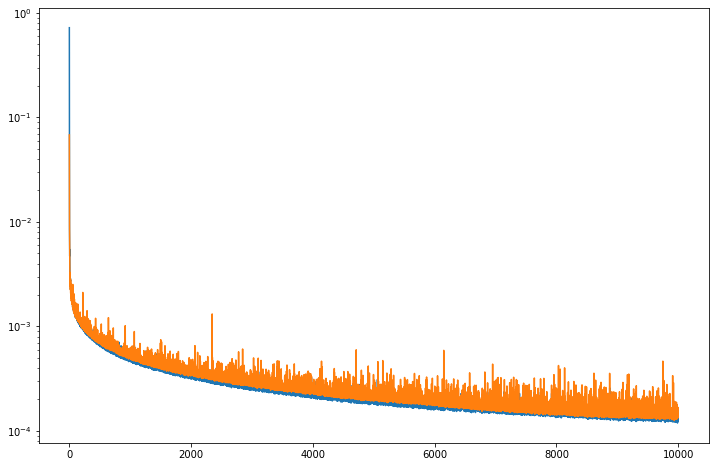

time: 1.03 s (started: 2021-05-24 08:18:11 +00:00)


In [22]:
lml.print_training_log("cyclesampling.log", onlyloss=True)

In [23]:
randfol="cycle_ndiff"
!mkdir {randfol}
maelist = list()
errorpd = pd.DataFrame()
for diff in np.arange(0.1, 4, 0.1):
    a = lml.n2n1diff_search(data_arr, diff, 1, 2)
    if len(a) < 1:
        continue
    testdiffx = a[:, :-1]
    testdiffy = a[:, -1]
    testdiffy = testdiffy.reshape(len(testdiffy), 1)
    testdiffxtr = scaler.transform(testdiffx)
    testres = cyclemodel(testdiffxtr).numpy().astype(float)
    maer = np.mean(np.abs(testres-testdiffy))
    maelist.append([diff, maer])
    metdict = {"diff": diff}
    metdict.update(lml.get_metric_scores(testres, testdiffy))
    add_data = [metdict]
    errorpd = errorpd.append(add_data, ignore_index=True, sort=False)
    unique, mean = npi.group_by(testdiffx[:, -2:]).mean(np.abs(testres - testdiffy))
    # instead of averaging over all values take maxerror at each height,width
    # since the higher ndiffs can't really average
    _, maxerr = npi.group_by(testdiffx[:, -2:]).max(np.abs(testres - testdiffy))
    np.savetxt(f"{randfol}/{diff:.1f}coo.csv", unique, delimiter=",")
    np.savetxt(f"{randfol}/{diff:.1f}val.csv", mean, delimiter=",")
    np.savetxt(f"{randfol}/{diff:.1f}maxval.csv", maxerr, delimiter=",")
errorpd.to_csv(f"{randfol}/errormetrics.csv", index_label="Index")
!zip -r {randfol}.zip {randfol}
files.download(f"{randfol}.zip")

mkdir: cannot create directory ‘cycle_ndiff’: File exists
updating: cycle_ndiff/ (stored 0%)
updating: cycle_ndiff/2.5val.csv (deflated 54%)
updating: cycle_ndiff/1.1val.csv (deflated 55%)
updating: cycle_ndiff/2.3maxval.csv (deflated 55%)
updating: cycle_ndiff/1.9coo.csv (deflated 94%)
updating: cycle_ndiff/0.6maxval.csv (deflated 56%)
updating: cycle_ndiff/2.5coo.csv (deflated 94%)
updating: cycle_ndiff/2.6coo.csv (deflated 94%)
updating: cycle_ndiff/1.2coo.csv (deflated 94%)
updating: cycle_ndiff/1.2maxval.csv (deflated 55%)
updating: cycle_ndiff/1.7val.csv (deflated 55%)
updating: cycle_ndiff/2.2coo.csv (deflated 94%)
updating: cycle_ndiff/1.2val.csv (deflated 55%)
updating: cycle_ndiff/0.5val.csv (deflated 55%)
updating: cycle_ndiff/1.4val.csv (deflated 55%)
updating: cycle_ndiff/1.1coo.csv (deflated 94%)
updating: cycle_ndiff/0.9val.csv (deflated 55%)
updating: cycle_ndiff/1.0val.csv (deflated 55%)
updating: cycle_ndiff/2.0coo.csv (deflated 94%)
updating: cycle_ndiff/1.7maxval.cs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 760 ms (started: 2021-05-24 08:18:12 +00:00)
